In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Wind Power Forecasting

In this notebook we're going to  to predict the wind power that could be generated from the windmill for the next 15 days.  We'll use ARIMA model for forecasting. 

Let's start

In [6]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving Turbine_Data.csv to Turbine_Data.csv
User uploaded file "Turbine_Data.csv" with length 23013864 bytes


In [13]:
df = pd.read_csv('Turbine_Data.csv')
df.tail()

,Unnamed: 0,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WTG,WindDirection,WindSpeed
118219,2020-03-30 23:10:00+00:00,70.044465,27.523741,45.711129,1.515669,1.950088,1.950088,0.0,59.821165,55.193793,1029.870744,59.060367,58.148777,39.008931,36.476562,178.0,13.775785,9.234004,2.0,G01,178.0,3.533445
118220,2020-03-30 23:20:00+00:00,40.833474,27.602882,45.598573,1.702809,2.136732,2.136732,0.0,59.142038,54.798545,1030.160478,58.452003,57.550367,39.006759,36.328125,178.0,8.088928,9.229370,2.0,G01,178.0,3.261231
118221,2020-03-30 23:30:00+00:00,20.777790,27.560925,45.462045,1.706214,2.139664,2.139664,0.0,58.439439,54.380456,1030.137822,58.034071,57.099335,39.003815,36.131944,178.0,4.355978,9.236802,2.0,G01,178.0,3.331839
118222,2020-03-30 23:40:00+00:00,62.091039,27.810472,45.343827,1.575352,2.009781,2.009781,0.0,58.205413,54.079014,1030.178178,57.795387,56.847239,39.003815,36.007805,190.0,12.018077,9.237374,2.0,G01,190.0,3.284468
118223,2020-03-30 23:50:00+00:00,68.664425,27.915828,45.231610,1.499323,1.933124,1.933124,0.0,58.581716,54.080505,1029.834789,57.694813,56.741040,39.003815,35.914062,203.0,14.439669,9.235532,2.0,G01,203.0,3.475205


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118224 entries, 0 to 118223
Data columns (total 22 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Unnamed: 0                    118224 non-null  object 
 1   ActivePower                   94750 non-null   float64
 2   AmbientTemperatue             93817 non-null   float64
 3   BearingShaftTemperature       62518 non-null   float64
 4   Blade1PitchAngle              41996 non-null   float64
 5   Blade2PitchAngle              41891 non-null   float64
 6   Blade3PitchAngle              41891 non-null   float64
 7   ControlBoxTemperature         62160 non-null   float64
 8   GearboxBearingTemperature     62540 non-null   float64
 9   GearboxOilTemperature         62438 non-null   float64
 10  GeneratorRPM                  62295 non-null   float64
 11  GeneratorWinding1Temperature  62427 non-null   float64
 12  GeneratorWinding2Temperature  62449 non-null

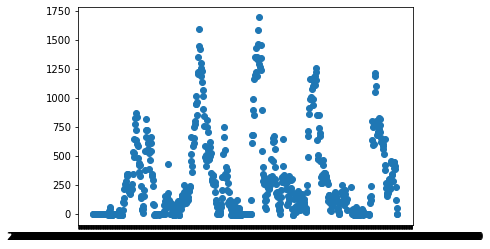

In [15]:
ig, ax = plt.subplots()
ax.scatter(df["Unnamed: 0"][:1000], df["ActivePower"][:1000])

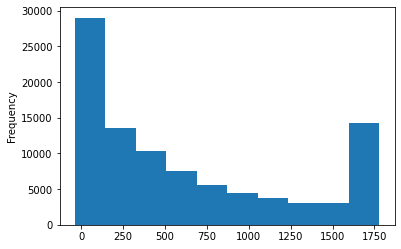

In [16]:
df.ActivePower.plot.hist()

## Parsing dates
When working with time series data, it's a good idea to make sure any date data is the format of a datetime object (a Python data type which encodes specific information about dates).

In [18]:
df = pd.read_csv('Turbine_Data.csv',
                 low_memory=False,
                 parse_dates=["Unnamed: 0"])

In [19]:
# With parse_dates... check dtype of "Unnamed: 0"
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118224 entries, 0 to 118223
Data columns (total 22 columns):
 #   Column                        Non-Null Count   Dtype              
---  ------                        --------------   -----              
 0   Unnamed: 0                    118224 non-null  datetime64[ns, UTC]
 1   ActivePower                   94750 non-null   float64            
 2   AmbientTemperatue             93817 non-null   float64            
 3   BearingShaftTemperature       62518 non-null   float64            
 4   Blade1PitchAngle              41996 non-null   float64            
 5   Blade2PitchAngle              41891 non-null   float64            
 6   Blade3PitchAngle              41891 non-null   float64            
 7   ControlBoxTemperature         62160 non-null   float64            
 8   GearboxBearingTemperature     62540 non-null   float64            
 9   GearboxOilTemperature         62438 non-null   float64            
 10  GeneratorRPM        

In [20]:
# duplicate the date column to change it's name 
df['DateTime'] = df['Unnamed: 0'] 
df.drop('Unnamed: 0', axis=1, inplace=True)

In [21]:
df['DateTime'].head(20)

0    2017-12-31 00:00:00+00:00
1    2017-12-31 00:10:00+00:00
2    2017-12-31 00:20:00+00:00
3    2017-12-31 00:30:00+00:00
4    2017-12-31 00:40:00+00:00
5    2017-12-31 00:50:00+00:00
6    2017-12-31 01:00:00+00:00
7    2017-12-31 01:10:00+00:00
8    2017-12-31 01:20:00+00:00
9    2017-12-31 01:30:00+00:00
10   2017-12-31 01:40:00+00:00
11   2017-12-31 01:50:00+00:00
12   2017-12-31 02:00:00+00:00
13   2017-12-31 02:10:00+00:00
14   2017-12-31 02:20:00+00:00
15   2017-12-31 02:30:00+00:00
16   2017-12-31 02:40:00+00:00
17   2017-12-31 02:50:00+00:00
18   2017-12-31 03:00:00+00:00
19   2017-12-31 03:10:00+00:00
Name: DateTime, dtype: datetime64[ns, UTC]

In [22]:
# Add datetime parameters 
df['DateTime'] = pd.to_datetime(df['DateTime'], 
 format = '%Y-%m-%dT%H:%M:%SZ', 
 errors = 'coerce')

df['year'] = df['DateTime'].dt.year
df['month'] = df['DateTime'].dt.month
df['day'] = df['DateTime'].dt.day
df['hour'] = df['DateTime'].dt.hour
df['minute'] = df['DateTime'].dt.minute

In [23]:
# Drop original DateTime column
df.drop('DateTime', axis=1, inplace= True)

In [24]:
df

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WTG,WindDirection,WindSpeed,year,month,day,hour,minute
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN,2017,12,31,0,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN,2017,12,31,0,10
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN,2017,12,31,0,20
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN,2017,12,31,0,30
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN,2017,12,31,0,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118219,70.044465,27.523741,45.711129,1.515669,1.950088,1.950088,0.0,59.821165,55.193793,1029.870744,59.060367,58.148777,39.008931,36.476562,178.0,13.775785,9.234004,2.0,G01,178.0,3.533445,2020,3,30,23,10
118220,40.833474,27.602882,45.598573,1.702809,2.136732,2.136732,0.0,59.142038,54.798545,1030.160478,58.452003,57.550367,39.006759,36.328125,178.0,8.088928,9.229370,2.0,G01,178.0,3.261231,2020,3,30,23,20
118221,20.777790,27.560925,45.462045,1.706214,2.139664,2.139664,0.0,58.439439,54.380456,1030.137822,58.034071,57.099335,39.003815,36.131944,178.0,4.355978,9.236802,2.0,G01,178.0,3.331839,2020,3,30,23,30
118222,62.091039,27.810472,45.343827,1.575352,2.009781,2.009781,0.0,58.205413,54.079014,1030.178178,57.795387,56.847239,39.003815,36.007805,190.0,12.018077,9.237374,2.0,G01,190.0,3.284468,2020,3,30,23,40


In [25]:
df.isna().sum()

ActivePower                     23474
AmbientTemperatue               24407
BearingShaftTemperature         55706
Blade1PitchAngle                76228
Blade2PitchAngle                76333
Blade3PitchAngle                76333
ControlBoxTemperature           56064
GearboxBearingTemperature       55684
GearboxOilTemperature           55786
GeneratorRPM                    55929
GeneratorWinding1Temperature    55797
GeneratorWinding2Temperature    55775
HubTemperature                  55818
MainBoxTemperature              55717
NacellePosition                 45946
ReactivePower                   23476
RotorRPM                        56097
TurbineStatus                   55316
WTG                                 0
WindDirection                   45946
WindSpeed                       23629
year                                0
month                               0
day                                 0
hour                                0
minute                              0
dtype: int64

In [26]:
# Fill numeric rows with the median
for label, content in df.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells if the data was missing our not
            df[label+"_is_missing"] = pd.isnull(content)
            # Fill missing numeric values with median since it's more robust than the mean
            df[label] = content.fillna(content.median())

In [27]:
df.isna().sum()

ActivePower                                0
AmbientTemperatue                          0
BearingShaftTemperature                    0
Blade1PitchAngle                           0
Blade2PitchAngle                           0
Blade3PitchAngle                           0
ControlBoxTemperature                      0
GearboxBearingTemperature                  0
GearboxOilTemperature                      0
GeneratorRPM                               0
GeneratorWinding1Temperature               0
GeneratorWinding2Temperature               0
HubTemperature                             0
MainBoxTemperature                         0
NacellePosition                            0
ReactivePower                              0
RotorRPM                                   0
TurbineStatus                              0
WTG                                        0
WindDirection                              0
WindSpeed                                  0
year                                       0
month     

In [28]:
# Turn categorical variables into numbers
for label, content in df.items():
    # Check columns which aren't numeric
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to inidicate whether sample had missing value
        df[label+"_is_missing"] = pd.isnull(content)
        # We add the +1 because pandas encodes missing categories as -1
        df[label] = pd.Categorical(content).codes+1

In [29]:
### Testing For Stationarity

from statsmodels.tsa.stattools import adfuller
test_result=adfuller(df['ActivePower'])
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(Power):
    result=adfuller(Power)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
        
adfuller_test(df['ActivePower'])

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


ADF Test Statistic : -21.00166405825862
p-value : 0.0
#Lags Used : 71
Number of Observations Used : 118152
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [30]:
# Import libraries required 
import pandas as pd
from pandas import Series
import numpy as np
import datetime
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt

import seaborn
from fbprophet import Prophet
import statsmodels.api as sm
import statsmodels.tsa as ts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from matplotlib import pyplot
import itertools as it
from matplotlib import mlab

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.



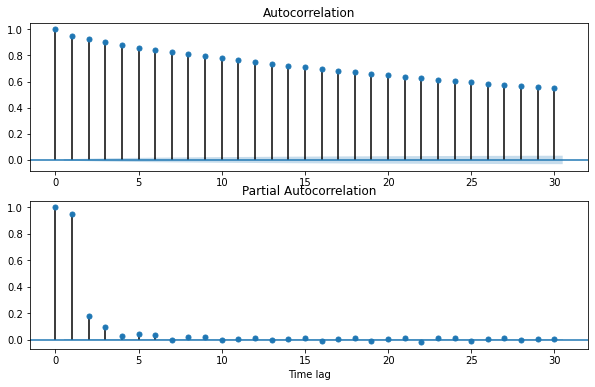

In [31]:
#Analysis of ACF and PACF on Close Price
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['ActivePower'], lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['ActivePower'], lags=30, ax=ax2)
plt.xlabel('Time lag')
plt.show()

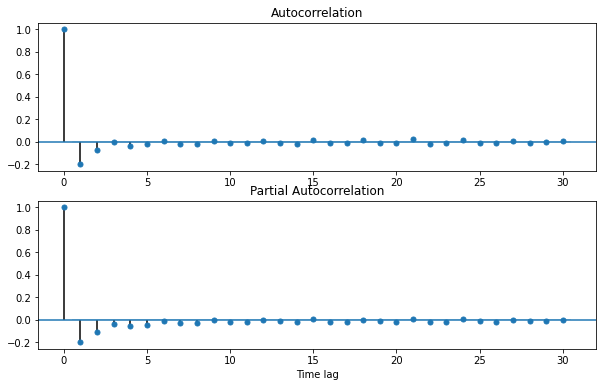

In [32]:
#Analysis of ACF and PACF on differece Close Price
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['ActivePower'].diff().dropna(), lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['ActivePower'].diff().dropna(), lags=30, ax=ax2)
plt.xlabel('Time lag')
plt.show()

### Modelling

In [33]:
from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(df['ActivePower'][:5000],order=(2,0,3))
model_fit=model.fit()

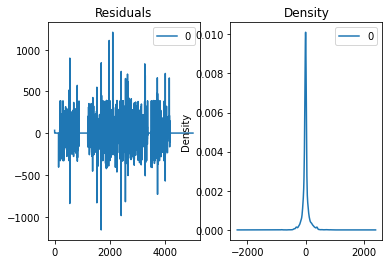

In [34]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

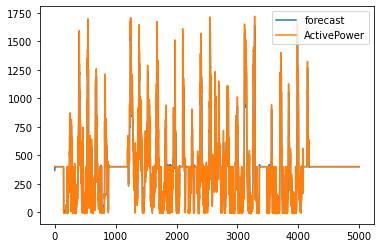

In [35]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False )
plt.show()

In [36]:
# splitting data into test and train datasets
from sklearn.model_selection import train_test_split
train = df['ActivePower'][:1000]
test = df['ActivePower'][1000:1015]

In [37]:
# Forecast
fc, se, conf = model_fit.forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

In [38]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)


{'corr': -6.188251068286327e-15,
 'mae': 10.543605038343602,
 'mape': 0.026185215213246925,
 'me': -10.543605038343602,
 'minmax': 0.026185215213246904,
 'mpe': -0.026185215213246925,
 'rmse': 11.626186003583731}

****Around 2.6% MAPE implies the model is about 97.4% accurate in predicting the next 15 observations.****

Please don't forget to upvote if my notebook helped you. 😀